# 데이터마이닝_워드클라우드

In [1]:
from bs4 import BeautifulSoup
import requests
import time
import re
import datetime
from tqdm import tqdm
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import pandas as pd
from PIL import Image
import numpy as np
%matplotlib inline
from konlpy.tag import Mecab
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from konlpy.tag import Kkma
pd.options.plotting.backend = "plotly"

#웹드라이버 설정
service = Service(executable_path=f"C:/Users/user/Desktop/학기별 문서/현장실습/크롤링_워드클라우드/chromedriver-win64/chromedriver.exe")
options = webdriver.ChromeOptions()
options.add_argument("headless")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

In [2]:
# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)
def makeUrl(search, start_pg, end_pg, s_date, e_date):
    urls = []
    s_from = s_date.replace(".", "")
    e_to = e_date.replace(".", "")
    for i in range(start_pg, end_pg + 1):
        page = makePgNum(i)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&sort=0&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "&start=" + str(page)
        urls.append(url)
#     print("생성url: ", urls)
    return urls    

In [12]:
# 검색어를 기준으로 1~10 페이지 Url 생성
keyword = input('input keyword : ')
s_date = input('input start_date : ')
e_date = input('input end_date : ')
url = makeUrl(keyword, 1, 10, s_date, e_date)



## selenium으로 navernews만 뽑아오기##
# 버전에 상관 없이 os에 설치된 크롬 브라우저 사용
driver = webdriver.Chrome(options=options, service=service)
driver.implicitly_wait(3)


# selenium으로 검색 페이지 불러오기 #
print("준비중...")
naver_urls=[]

for i in url:
    driver.get(i)
    time.sleep(1) #대기시간 변경 가능

    # 네이버 기사 눌러서 제목 및 본문 가져오기#
    # 네이버 기사가 있는 기사 css selector 모아오기
    a = driver.find_elements(By.CSS_SELECTOR,'a.info')

    # 위에서 생성한 css selector list 하나씩 클릭하여 본문 url얻기
    for i in a:
        # 네이버 뉴스 url만 가져오기
        if i.text == '네이버뉴스':
            i.click()

            # 현재탭에 접근
            driver.switch_to.window(driver.window_handles[1])
            driver.implicitly_wait(3) #대기시간 변경 가능

            # 네이버뉴스의 특정 도메인만을 수집
            url = driver.current_url
            if url.find("n.news.naver.com") != -1:
                print(url)
                naver_urls.append(url)

            # 현재 탭 닫기
            driver.close()

            # 다시처음 탭으로 돌아가기(매우 중요!!!)
            driver.switch_to.window(driver.window_handles[0])

if len(naver_urls) == 0:
    print("크롤링 할 수 있는 뉴스기사가 없습니다...")
else:
    print("모든 기사 url 수집 완료")

input keyword : 칼부림
input start_date : 2023.08.05
input end_date : 2023.08.06
준비중...
https://n.news.naver.com/mnews/article/003/0012015618?sid=102
https://n.news.naver.com/mnews/article/001/0014114808?sid=102
https://n.news.naver.com/mnews/article/025/0003298833?sid=102
https://n.news.naver.com/mnews/article/016/0002179590?sid=101
https://n.news.naver.com/mnews/article/055/0001079297?sid=102
https://n.news.naver.com/mnews/article/021/0002586840?sid=102
https://n.news.naver.com/mnews/article/003/0012015789?sid=102
https://n.news.naver.com/mnews/article/055/0001079322?sid=102
https://n.news.naver.com/mnews/article/079/0003798941?sid=102
https://n.news.naver.com/mnews/article/437/0000354215?sid=102
https://n.news.naver.com/mnews/article/022/0003841973?sid=102
https://n.news.naver.com/mnews/article/016/0002179673?sid=102
https://n.news.naver.com/mnews/article/417/0000940323?sid=102
https://n.news.naver.com/mnews/article/421/0006973743?sid=102
https://n.news.naver.com/mnews/article/011/0004

In [13]:
###naver 기사 본문 및 제목 가져오기###

# ConnectionError방지
headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102" }

titles = []
contents=[]
num = 1
print("제목, 본문 가져오는중...")
for i in naver_urls:
    original_html = requests.get(i,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")
    # 검색결과확인시
    # print(html)
    
    #뉴스 제목 가져오기
    title = html.select("div.media_end_head_title > h2")
    
    # list합치기
    title = ''.join(str(title))
    
    # html태그제거
    pattern1 = '<[^>]*>'
    title = re.sub(pattern=pattern1,repl='',string=title)
    
    # 출력
    titles.append(title[1:len(title)-1])
    print(str(num) + ". " + title[1:len(title)-1])
    num = num + 1
    
    #뉴스 본문 가져오기
    content = html.select("div#contents > div#newsct_article")

    # list합치기
    content = ''.join(str(content))
    
    #html태그제거 및 텍스트 다듬기
    content = re.sub(pattern=pattern1,repl='',string=content)
    pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2,'')

    contents.append(content)

# csv 파일로 기사제목과 url 저장
# data = {"url" : naver_urls, "title" : titles}
# df = pd.DataFrame(data)
# df.to_csv(keyword + ".csv", encoding = "utf-8-sig")
    
titles_all = ""
contents_all = ""
news_all = ""

# 기사 별 제목 모두 합치기(string)
for i in titles:
    titles_all = titles_all + " " + i

# 기사 별 내용 모두 합치기(string)
for i in contents:
    contents_all = contents_all + " " + i

# 제목 + 기사 모두 합치기(string)
news_all = titles_all + contents_all

# 네이버뉴스의 태그가 위 조건에 맞지 않아 뉴스가 없을 경우 예외처리 
if len(news_all) == 0 :
    print("크롤링 실패..")
else:
    print("모든 기사 제목/본문 크롤링 완료")

제목, 본문 가져오는중...
1. '원주역 칼부림' 예고 SNS, 잡고보니 10대
2. "세종 00중학교 칼부림"…살인예고 글 올린 10대 잇따라 검거
3. "부산 서면 칼부림 예고" 해군 일병 짓이었다…헌병대 인계
4. “내몸 지켜야”…묻지마 칼부림에 호신용품 주문 급증
5. 대전 은행동·세종 칼부림…살인예고 글 올린 10대들 검거
6. “원주역서 칼부림 저지르겠다”…예고 글 올린 10대 검거
7. "고양 상가서 칼부림하겠다" 예고글 올린 10대 검거
8. 분당 칼부림 피의자, 범행 전 휴대전화로 '칼·가스총' 검색
9. '나도 관심 받을 수 있을까?'…'칼부림 예고'한 10대들 경찰 덜미
10. "혜화역서 칼부림 벌이겠다"…당근마켓 글 올린 30대 긴급체포
11. ‘서현역 칼부림 사건’ 차에 친 여성 사망…피의자 혐의 ‘살인’으로 변경
12. 서현역 칼부림 이후 쏟아진 '살인예고' …하루새 28명 검거
13. '칼부림 예고글' 작성자에 살인예비 혐의 적용… 신림역 사건 이후 처음
14. '원주역 칼부림 예고'…검거된 용의자는 영월 10대 청소년
15. 安, '묻지마 칼부림'에 "내년부터 전국민 정신건강 검진해야"
16. '청주 칼부림 예고지역 목록' 글 유포한 30대 자수…"장난으로 보내"
17. ‘묻지마 칼부림’에 전국이 떤다...‘살인 예고’ 게시글만 42건
18. "다음은 구미역 칼부림이다"…인터넷 글 올린 10대 긴급체포
19. "칼부림 난동범 오인 받은 중학생 아들…경찰이 피범벅 만들어"
20. "강남 성형외과서 칼부림" 살인예고 글 올린 20대 등 검거
21. “칼부림 났어요”… 쏟아지는 가짜뉴스에 경찰력 소모
22. "가스 테러""난동범 있다"…지하철 오인신고에 대피소동(종합)
23. 광주경찰 '학교 칼부림 예고' 협박범 검거
24. 대구 삼성라이온즈파크 칼부림 예고글…경찰, 현장 투입
25. ‘서현역 칼부림 사건’ 피의자, 사이코패스 검사 검토 “정신과 진료 이력 확인돼”
26. 칼부림만 무서운게 아니다…지갑 닫히게한 '집콕' 세가지 이유
2

('경찰', 478)
('예고', 287)
('살인', 284)
('흉기', 270)
('사건', 206)
('난동', 204)
('게시', 151)
('검거', 142)
('혐의', 134)
('서울', 119)
('범죄', 115)
('경찰청', 112)
('온라인', 109)
('지난', 107)
('범행', 104)
('시민', 85)
('서현역', 81)
('신고', 81)
('조사', 81)
('수사', 76)
('작성자', 74)
('배치', 72)
('장난', 71)
('전국', 69)
('남성', 67)
('협박', 66)
('피의자', 64)
('사람', 62)
('커뮤니티', 62)
('고글', 61)
('경기', 61)
('사진', 59)
('대해', 58)
('추적', 55)
('백화점', 55)
('국민', 54)
('전날', 54)
('진술', 53)
('인터넷', 52)
('분당', 51)
('확인', 50)
('최씨', 50)
('이후', 49)
('인근', 48)
('불안감', 46)
('치안', 45)
('활동', 45)
('작성', 44)
('처벌', 44)
('위해', 44)
('부산', 43)
('순찰', 43)
('지역', 41)
('성남시', 41)
('적용', 40)
('신림역', 40)
('구속', 40)
('가운데', 40)
('대전', 38)
('현장', 38)
('대한', 38)
('내용', 37)
('장갑차', 36)
('통해', 36)
('대구', 35)
('경찰서', 35)
('특별', 35)
('특정', 35)
('접수', 35)
('호신용품', 34)
('대응', 34)
('장소', 34)
('긴급', 33)
('관계자', 33)
('관련', 33)
('최근', 33)
('상황', 33)
('교사', 33)
('체포', 31)
('불안', 31)
('미성년', 31)
('적극', 30)
('보고', 30)
('형사', 30)
('예비', 29)
('테러', 29)
('특공대', 29)
('대상', 2

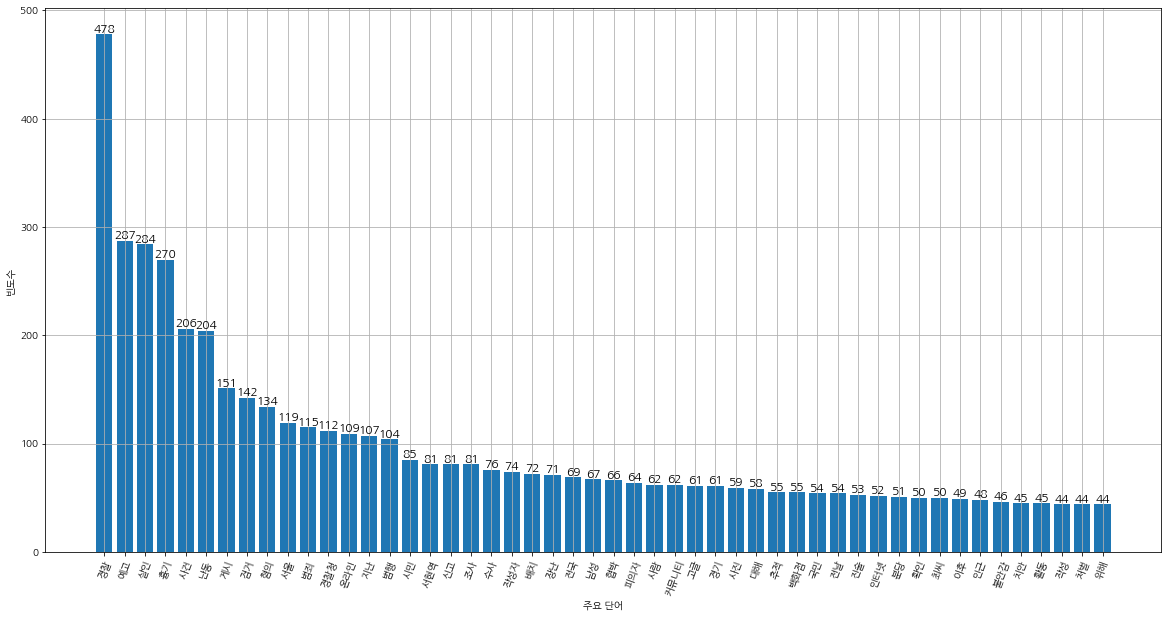

In [14]:
okt = Okt()

noun = okt.nouns(news_all)

nouns = []
# 두글자 이상 단어만 취급
word = [w for w in noun if len(w) > 1]
nouns.extend(word)

nouns = [i for i in nouns if i not in keyword]

# 빈도수 계산
count = Counter(nouns)

# 제거할 불필요한 단어 리스트
ignore = ["오전", "오후", "기자", "뉴스", "연합뉴스", "최대", "최소", "경우", "정도", "예상", "회의", "단계", "발생", "가장", "올해", "평소"]
for word in ignore:
    if word in count:
        del count[word] # 제거

# 상위 100개 단어 출력
noun_list = count.most_common(100)
for v in noun_list:
    print(v)
    
# 빈도수 그래프 나타내기
wordInfo = dict() # 딕셔너리
for tags, counts in count.most_common(50):
    wordInfo[tags] = counts

Sorted_Dict_Values = sorted(wordInfo.values(), reverse=True) # 빈도수 저장
Sorted_Dict_Keys = sorted(wordInfo, key=wordInfo.get, reverse=True) # 단어 저장

# 전역으로 그래프 사이즈 고정
plt.rcParams["figure.figsize"] = (12,5)

# 유니코드 깨짐현상 해결
plt.rcParams['axes.unicode_minus'] = False
    
# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

# 바 그래프 그리기
plt.figure(figsize = (20,10))
bar = plt.bar(range(len(wordInfo)), Sorted_Dict_Values, align='center')
plt.xticks(range(len(wordInfo)), list(Sorted_Dict_Keys), rotation='70')
plt.xlabel("주요 단어")
plt.ylabel("빈도수")
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, '%d' % height, ha='center', va='bottom', size = 12)
plt.grid()
plt.show()

(-0.5, 799.5, 599.5, -0.5)

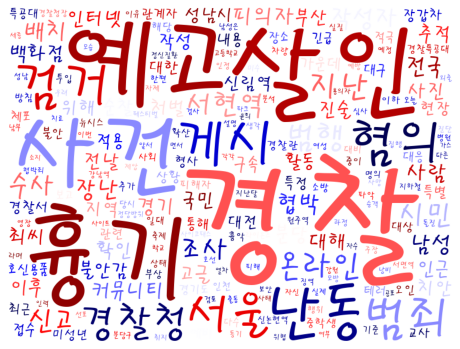

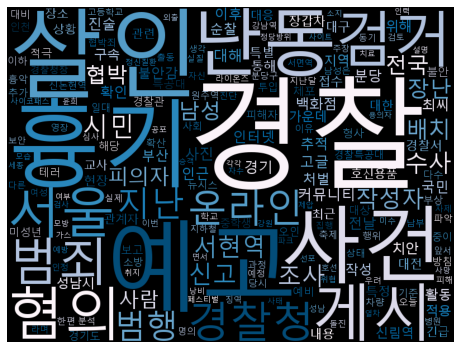

In [15]:
# 워드 클라우드 구현
wc = WordCloud(font_path = 'C:/Windows/Fonts/HMFMPYUN.ttf', background_color = 'white', colormap = 'seismic',width = 800, height = 600, prefer_horizontal = True) # malgun = 맑음 # spring, summer, seismic, PuBu
cloud = wc.generate_from_frequencies(count)
plt.figure(figsize = (8,8))
plt.imshow(cloud)
plt.axis('off')

wc2 = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color = 'black', colormap = 'PuBu',width = 800, height = 600, prefer_horizontal = True) # malgun = 맑음 # spring, summer, seismic, PuBu
cloud2 = wc2.generate_from_frequencies(count)
plt.figure(figsize = (8,8))
plt.imshow(cloud2)
plt.axis('off')

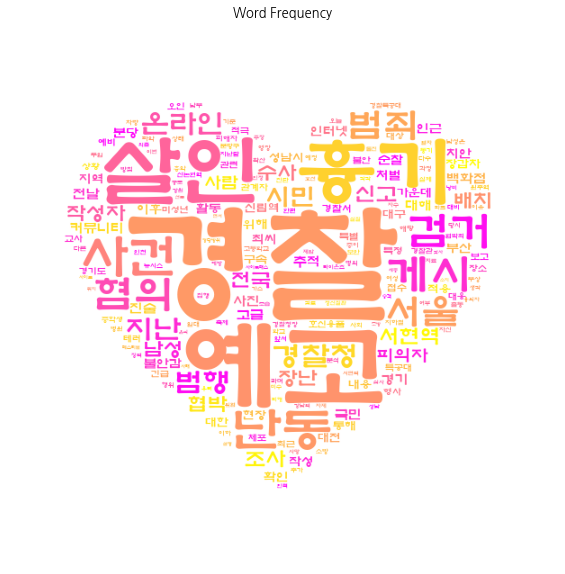

In [17]:
im = Image.open('.jpg') # 이미지 파일 읽어오기
mask_arr = np.array(im) # 픽셀 값 배열 형태 변환

wordcloud = WordCloud(font_path = 'HMFMOLD', background_color ='white', colormap='spring',
                      width = 800, height = 600, random_state = 43, mask = mask_arr,
                      prefer_horizontal = True).generate_from_frequencies(count)

plt.figure(figsize = (10, 10))  
plt.imshow(wordcloud)
plt.title("Word Frequency", size = 13)

plt.axis('off')

plt.show()